In [1]:
import requests

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

# The SIR model  

<img src="./media/Typical-SIR-model-solution-showing-progression-of-population-disease-states-for.PNG" style="float:left; width:500px"/>  

<br clear="all">

$\dfrac{dS}{dt} = - \dfrac{\beta I S}{N}$  

$\dfrac{dI}{dt} = \dfrac{\beta I S}{N} - \gamma I$  

$\dfrac{dR}{dt} = \gamma I$  

with $R_0 = \dfrac{\beta}{\gamma}$.  

### In the initial stages of propagation the nº of infected is exponential with rate $R_0$ (confirm)  

### Explain why the appearence of more sources does not change the evolution rate  

### How to estimate $R_0$?  
* The effect of testing (with know only a percentage of infeted)
* The effect of social distancing measures

### Estimate the impact of lockdown on $R_0$

# World Population  

[This UN source](https://data.un.org/Data.aspx?d=PopDiv&f=variableID%3a12%3btimeID%3a83%2c84%3bvarID%3a2&c=2,4,6,7&s=_crEngNameOrderBy:asc,_timeEngNameOrderBy:desc,_varEngNameOrderBy:asc&v=1#PopDiv) was used.

In [618]:
filename = "./data/UNdata_Export_20200324_225732447.csv"

# read csv data file into a DataFrame
df_population = pd.read_csv(filename)

In [619]:
df_population.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 570 entries, 0 to 569
Data columns (total 4 columns):
Country or Area    570 non-null object
Year(s)            570 non-null int64
Variant            570 non-null object
Value              570 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 17.9+ KB


In [620]:
df_population.columns = ['country', 'year', 'variant', 'million_people']
df_population['million_people'] = df_population['million_people']/1000
df_population['country'] = df_population['country'].str.lower()
df_population = df_population.loc[df_population.year == 2019]
df_population = df_population.drop(columns='variant')
df_population = df_population.drop_duplicates()

In [621]:
# validate no duplicate values
assert df_population.country.duplicated().sum() == 0

# Import the COVID data

### Data Sources  


* https://github.com/datasets/covid-19
* https://github.com/CSSEGISandData/COVID-19
* https://www.ecdc.europa.eu/en/publications-data/download-todays-data-geographic-distribution-covid-19-cases-worldwide

In [644]:
# We will be using the first data source

url = "https://raw.githubusercontent.com/datasets/covid-19/master/data/time-series-19-covid-combined.csv"
r = requests.get(url)

filename = "./data/covid_panel_data_aggregation.csv"

f = open(filename, "w") 
f.write(r.text) 
f.close()

# read csv data file into a DataFrame
df_original = pd.read_csv(filename)

In [645]:
# Tidy DataFrame

def tidy_df(df_original):
    
    df_tidy = df_original.copy()
    
    # simplify 'Country/Region' and Province/State'    
    df_tidy = df_tidy.rename(columns={'Country/Region': 'country','Province/State': 'state'})
    
    # conver column names to lower case
    df_tidy.columns = df_tidy.columns.str.lower()
    
    # Convert Date from string to datetime
    df_tidy["date"] = pd.to_datetime(df_tidy.date)
    
    # Convert string values to lower case
    df_tidy['country'] = df_tidy.country.str.lower()
    df_tidy['state'] = df_tidy.state.str.lower()
    
    # Fill string nans with ''
    df_tidy['state'] = df_tidy.state.fillna('')
    
    # If country equals the state (e.g., france, united kingdom, us,...) remove the state
    df_tidy.loc[df_tidy.country==df_tidy.state, 'state'] = ""
    
    df_tidy = df_tidy.sort_values(by=['country', 'state', 'date'])
    
    return df_tidy


In [646]:
df = tidy_df(df_original)

In [647]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15183 entries, 0 to 14552
Data columns (total 8 columns):
date         15183 non-null datetime64[ns]
country      15183 non-null object
state        15183 non-null object
lat          15183 non-null float64
long         15183 non-null float64
confirmed    15183 non-null int64
recovered    14074 non-null float64
deaths       15183 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(2), object(2)
memory usage: 1.0+ MB


In [366]:
df.head()

,date,country,state,lat,long,confirmed,recovered,deaths
0,2020-01-22,afghanistan,,33.0,65.0,0,0.0,0
1,2020-01-23,afghanistan,,33.0,65.0,0,0.0,0
2,2020-01-24,afghanistan,,33.0,65.0,0,0.0,0
3,2020-01-25,afghanistan,,33.0,65.0,0,0.0,0
4,2020-01-26,afghanistan,,33.0,65.0,0,0.0,0


In [681]:
#df.groupby('date')['confirmed','deaths'].sum().plot()

In [682]:
#df.groupby('date').sum().loc["2020-03-20":"2020-03-24"]

# Daily country-level analysis

### Build DataFrame

In [712]:
# Create new DataFrame for country-level analysis
df_today = df.copy()

# record last available date
last_date = df_today.date.max()

# Drop unused columns
df_today = df_today.drop(columns=['state', 'lat', 'long'])

# Group by country and date
df_today = df_today.groupby(['country', 'date']).sum().sort_index()

# Build variables to use afterward
df_today['currently intected'] = df_today['confirmed'] - df_today['recovered']
#df_today = df_today.drop(columns=['confirmed', 'recovered'])

df_today['currently intected increase'] = df_today['currently intected'].diff()

df_today['deaths increase'] = df_today['deaths'].diff()

# df_today = df_today[['confirmed', 'recovered', 'currently intected', 'currently intected increase', 'deaths', 'deaths increase']]
df_today = df_today[['currently intected', 'currently intected increase', 'deaths', 'deaths increase']]


In [720]:
df_today.reset_index(level='date')

#df3.index = df3.index.droplevel(0)

,date,currently intected,currently intected increase,deaths,deaths increase
country,,,,,
afghanistan,2020-03-24,74.0,35.0,1,0.0
albania,2020-03-24,123.0,21.0,5,1.0
algeria,2020-03-24,264.0,99.0,19,2.0
andorra,2020-03-24,164.0,32.0,1,0.0
angola,2020-03-24,3.0,0.0,0,0.0
antigua and barbuda,2020-03-24,3.0,0.0,0,0.0
argentina,2020-03-24,387.0,89.0,6,2.0
armenia,2020-03-24,249.0,16.0,0,0.0
australia,2020-03-24,2044.0,450.0,8,1.0


In [ ]:
# Keep last available values
last_date = df_today.index.get_level_values('date').max()

idx = pd.IndexSlice
df_today = df_today.loc[idx[:,last_date], :]
df_today = 

In [711]:
df_today[[:,:],:]

SyntaxError: invalid syntax (<ipython-input-711-d4539703265d>, line 1)

In [665]:
last_date - pd.Timedelta('10 D')

Timestamp('2020-03-14 00:00:00')

In [ ]:
# Select cross section of countries
cs_countries = df_today.groupby('country')[variable].sum()

### Choose variable

In [629]:
# choose variable: confirmed, recovered, deaths
variable = "confirmed"

### Choose data format

In [630]:
# choose data format: total or new
data_format = "new"

---

In [631]:
# Confirm aceptable value for variable
assert variable in ['confirmed', 'recovered', 'deaths']

# Confirm acceptable value for data_format
assert data_format in ['total', 'new']

In [633]:
# If analysis of new cases compute difference from previous day
if data_format == "new":
    df_today.loc[:,['confirmed', 'recovered', 'deaths']] = df_today.loc[:,['confirmed', 'recovered', 'deaths']].diff(periods=1)
    

In [634]:
# select last available date
last_date = df.date.drop_duplicates().sort_values().iloc[-1]
last_date

Timestamp('2020-03-23 00:00:00')

In [635]:
df_today = df_today.loc[df_today.date == last_date,: ].reset_index(drop=True)
df_today = df_today.loc[:, ['date', 'country', 'confirmed', 'recovered', 'deaths']]

In [636]:
# Select cross section of countries
cs_countries = df_today.groupby('country')[variable].sum()

In [637]:
# select top-level countries plus portugal
top_number = 10
top_list = cs_countries.sort_values(ascending=False).iloc[:top_number].index.tolist()

if "portugal" not in top_list:
    top_list.append("portugal")

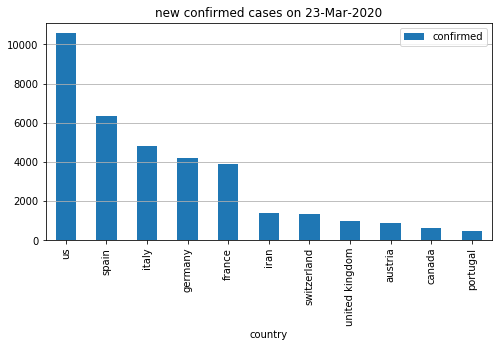

In [638]:
cs_countries.loc[top_list].to_frame().plot.bar(figsize=(8,4))

plt.grid(axis='y')
plt.legend()

plt.title('{} {} cases on {}'.format(data_format, variable, last_date.strftime("%d-%b-%Y")))
plt.ylabel('');

In [639]:
df_today

,date,country,confirmed,recovered,deaths
0,2020-03-23,afghanistan,0.0,0.0,0.0
1,2020-03-23,albania,15.0,0.0,2.0
2,2020-03-23,algeria,29.0,0.0,0.0
3,2020-03-23,andorra,20.0,0.0,0.0
4,2020-03-23,angola,1.0,0.0,0.0
5,2020-03-23,antigua and barbuda,2.0,0.0,0.0
6,2020-03-23,argentina,35.0,0.0,0.0
7,2020-03-23,armenia,41.0,0.0,0.0
8,2020-03-23,australia,13.0,0.0,0.0
9,2020-03-23,australia,0.0,0.0,0.0


In [642]:
pd.merge(df_today, df_population, how='left', on='country', validate='many_to_one')

,date,country,confirmed,recovered,deaths,year,million_people
0,2020-03-23,afghanistan,0.0,0.0,0.0,2019.0,38.041754
1,2020-03-23,albania,15.0,0.0,2.0,2019.0,2.880917
2,2020-03-23,algeria,29.0,0.0,0.0,2019.0,43.053054
3,2020-03-23,andorra,20.0,0.0,0.0,2019.0,0.077142
4,2020-03-23,angola,1.0,0.0,0.0,2019.0,31.825295
5,2020-03-23,antigua and barbuda,2.0,0.0,0.0,2019.0,0.097118
6,2020-03-23,argentina,35.0,0.0,0.0,2019.0,44.780677
7,2020-03-23,armenia,41.0,0.0,0.0,2019.0,2.957731
8,2020-03-23,australia,13.0,0.0,0.0,2019.0,25.203198
9,2020-03-23,australia,0.0,0.0,0.0,2019.0,25.203198


2

In [ ]:
pd.merge(df_clean, df_hospitais_codes, how='left', on='clean_name', validate='many_to_one')

---

# Single country analysis - time series

### Choose country, state

In [549]:
# choose country
country = "spain"

# choose state
state = ""

### Choose variable

In [550]:
# choose variable: confirmed, recovered, deaths
variable = "confirmed"

### Choose data format

In [551]:
# choose data format: total or new
data_format = "new"

---

In [552]:
# Confirm aceptable values for country and state
assert country in df.country.values
assert state in df.loc[df.country==country].state.values

# Confirm aceptable value for variable
assert variable in ['confirmed', 'recovered', 'deaths']

# Confirm acceptable value for data_format
assert data_format in ['total', 'new']

In [553]:
# same DataFrame but only for one country
df_country = df.loc[(df.country==country) & (df.state==state)].reset_index(drop = True).sort_values(by='date')

# confirm that we have only one observation per day
assert df_country.date.duplicated().sum() == 0

# set data as DataFrame index
df_country = df_country.set_index('date')

In [555]:
# drop values before the number of comfirmed cases exceeds a minimum number of cases (min_num_cases)
min_num_cases = 1000

first_date = df_country['confirmed'].loc[df_country['confirmed'] > min_num_cases].index[0]
#first_date

In [556]:
if data_format == "new":
    df_country.loc[:,['confirmed', 'recovered', 'deaths']] = df_country.loc[:,['confirmed', 'recovered', 'deaths']].diff(periods=1)
    

### time-trend plot

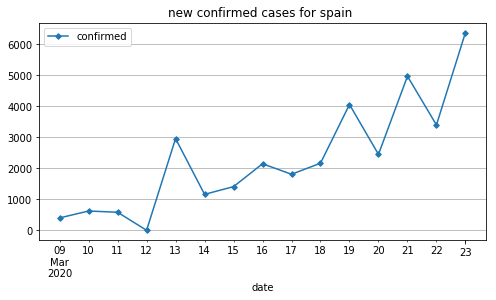

In [557]:
plt.figure(figsize=(8,4))
df_country[variable].loc[first_date:].plot(marker='D', markersize=4)

plt.grid(axis='y')
plt.legend()

plt.title('{} {} cases for {} {}'.format(data_format, variable, country, state))
plt.ylabel('');

### time-trend plot (log scale)

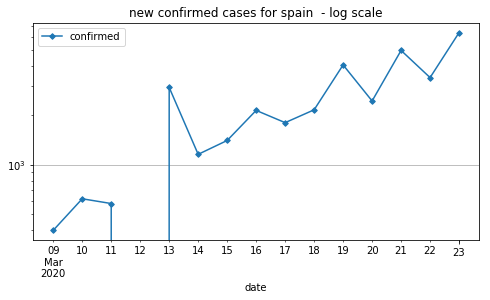

In [559]:
plt.figure(figsize=(8,4))
df_country[variable].loc[first_date:].plot(marker='D', markersize=4, logy=True)

plt.grid(axis='y')
plt.legend()

plt.title('{} {} cases for {} {} - log scale'.format(data_format, variable, country, state))
plt.ylabel('');

### daily growth rate

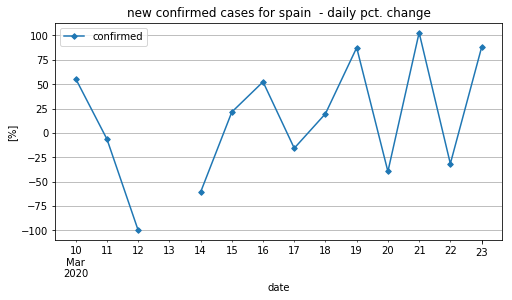

In [560]:
plt.figure(figsize=(8,4))
df_country[variable].loc[first_date:].pct_change().multiply(100).plot(marker='D', markersize=4)

plt.grid(axis='y')
plt.legend()

plt.title('{} {} cases for {} {} - daily pct. change'.format(data_format, variable, country, state))
plt.ylabel('[%]');

### daily growth rate - rolling mean

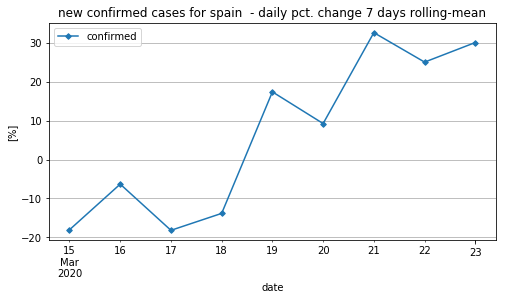

In [561]:
num_days = 7

plt.figure(figsize=(8,4))
df_country[variable].loc[first_date:].pct_change().multiply(100).rolling(num_days, min_periods=num_days-2).mean().plot(marker='D', markersize=4)

plt.grid(axis='y')
plt.legend()

plt.title('{} {} cases for {} {} - daily pct. change {} days rolling-mean'.format(data_format, variable, country, state, num_days))
#plt.title('Daily pct. change of {} cases for {} {} - {} days rolling-mean'.format(variable, country, state, num_days))
plt.ylabel('[%]');


---

### Nº of days to double cases

In [241]:
daily_growth = 0.05

In [242]:
num_days_to_double = (np.log(2))/(np.log(1+daily_growth))
num_days_to_double

14.206699082890463

In [582]:
x =np.arange(0,30,1)
y = 1000*(1+0.1)**x

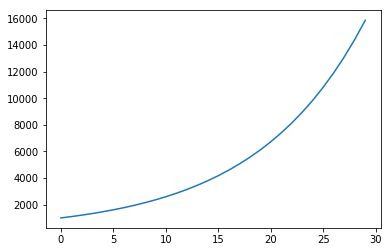

In [583]:
plt.plot(x, y);

In [584]:
ys = pd.Series(y)

In [585]:
ys.pct_change()

0     NaN
1     0.1
2     0.1
3     0.1
4     0.1
5     0.1
6     0.1
7     0.1
8     0.1
9     0.1
10    0.1
11    0.1
12    0.1
13    0.1
14    0.1
15    0.1
16    0.1
17    0.1
18    0.1
19    0.1
20    0.1
21    0.1
22    0.1
23    0.1
24    0.1
25    0.1
26    0.1
27    0.1
28    0.1
29    0.1
dtype: float64

In [587]:
ys.diff().pct_change()

0     NaN
1     NaN
2     0.1
3     0.1
4     0.1
5     0.1
6     0.1
7     0.1
8     0.1
9     0.1
10    0.1
11    0.1
12    0.1
13    0.1
14    0.1
15    0.1
16    0.1
17    0.1
18    0.1
19    0.1
20    0.1
21    0.1
22    0.1
23    0.1
24    0.1
25    0.1
26    0.1
27    0.1
28    0.1
29    0.1
dtype: float64

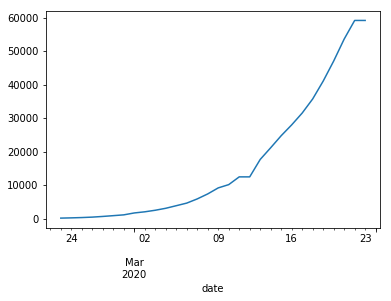

In [10]:
s.plot()

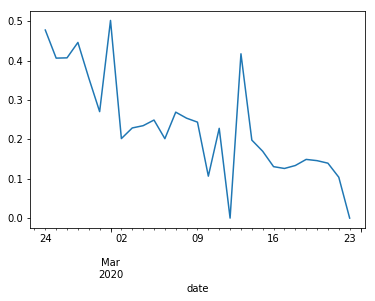

In [11]:
s.pct_change().plot()

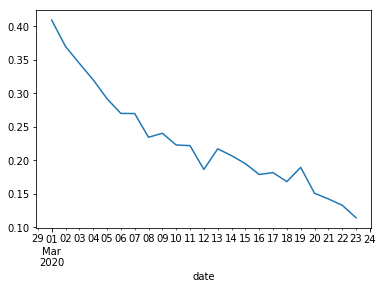

In [12]:
s.pct_change().rolling(7).mean().plot()

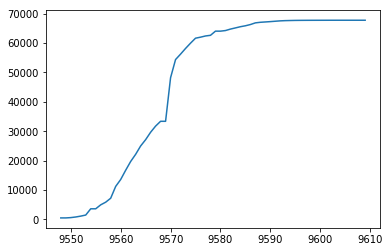

In [13]:
df.loc[(df.country=="China") & (df.state=="Hubei"),:].confirmed.plot()